In [1]:
import sys
sys.path.append('/Volumes/yyx_DISK/despotic')
import numpy as np
import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
from matplotlib.colors import LogNorm
from scipy.optimize import brentq
import matplotlib.cm as cm
import matplotlib.colors as colors
from despotic import emitter
from despotic.winds import pwind, zetaM, sxMach
from astropy.io import fits
# Constants; switch to cgs
from scipy.constants import G, c, m_p, m_e, h
from scipy.constants import k as kB
from astropy.units import Msun, yr, Angstrom, pc
# interact
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import emcee

sys.path.append('/Volumes/yyx_DISK/mcmc_code')
import wind_obs_diag_pkg as wodp
import wind_obs_diag_pkg_interact as wodpi

# directory of data
dat_dir = 'wind_data'


#import yt
c = 1e2*c
hP = h*1e7
G = 1e3*G
kB = 1e7*kB
mH = (m_e + m_p)*1e3
muH = 1.4
Msun = Msun.to('g')
yr = yr.to('s')
Myr = 1e6*yr
Gyr = 1e9*yr
ang = Angstrom.to('cm')
pc = pc.to('cm')
kpc = 1e3*pc
# Fiducial parameters
mdotstar = 4.1*Msun/yr
epsff = 0.01
mach = 100.0
uh = 10.0
v0 = 120e5*np.sqrt(2)
r0 = 250*pc
m0 = v0**2*r0/(2.0*G)
rho0 = 3.0*m0/(4.0*np.pi*r0**3)
tc = r0/v0
temp = 50.
dist = 3.5e3*kpc

<a id="contents"></a>
# Contents:
***
## [M82](#m82)

#### [basic data manipulation](#dat_m)
#### [image & spectrums](#img&spct)
#### [MCMC fitting](#mcmc)
#### [Comparing theory and observation](#compare)
***

<a id='m82'></a>
## M82


<a id='dat_m'></a>
### Basic data manipulation
[Back](#contents)

In [2]:
# emission line data
obj = 'M82'
#3.6Mpc (Freedman et al. 1994) so that 1''=17.5 pc and 1'=1 kpc
# systematic velocity 211 km/s 

# CO cold molecular gas; Leroy15 CO 2->1
CO_2_1 = fits.open('%s/%s/Leroy15/ngc3034_hans_I_CO_J1-2_lwb2009.fits'%(dat_dir, obj))

# cold neutron gas; Martini18 HI 21cm
HI = fits.open('%s/%s/Martini18/m82_hi_24as_rotated.fits'%(dat_dir, obj))

# emission  Warm ionized gas
# Ha Martin98 
# north pos_a~1kpc

# infomation on the data
# Leroy15
print('CO')
print(CO_2_1.info(),'\n')
print([CO_2_1[0].header])
print(CO_2_1[0].__dict__.keys(),'\n\n')
# spatial resolution 4''; beam size 20''(0.35 kpc);
# At this resolution, noise per 5.2 km s−1 channel of 7 mK in units of main beam temperature
# load data
CO_2_1 = CO_2_1[0].data
CO_2_1 = CO_2_1[::-1,:, :]

print('HI')
print(HI.info(),'\n')
print([HI[0].header])
print(HI[0].__dict__.keys(),'\n\n')
# spatial resolution 1'; beam size 24''.
# spectral res -5.000005412925e+03 km/s, right edge 5.696760655716E+05
# noise 4K per beam
# RMS     =       0.410808850362 /RMS Noise 
# load data
HI = HI[0].data
HI = HI[::-1,::-1, ::-1]

CO
Filename: wind_data/M82/Leroy15/ngc3034_hans_I_CO_J1-2_lwb2009.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      41   (255, 234, 232)   float64   
None 

[SIMPLE  =                    T / Written by IDL:  Sun Apr 24 18:20:31 2011      
BITPIX  =                  -64 / IEEE double precision floating point           
NAXIS   =                    3 / Number of data axes                            
NAXIS1  =                  255 /                                                
NAXIS2  =                  234 /                                                
NAXIS3  =                  232 /Updated by downsample_cube.pro                  
DATE    = '2010-02-02'         / Creation UTC (CCCC-MM-DD) date of FITS header  
COMMENT FITS (Flexible Image Transport System) format is defined in 'Astronomy  
COMMENT and Astrophysics', volume 376, page 359; bibcode 2001A&A...376..359H    
CTYPE3  = 'VELOCITY'           /M/S                        

In [3]:
#### zoom in and rotate
# CO_2_1
CO_2_1[np.isnan(CO_2_1)==True]=0

# rotate the 2D data to make the major axis x axis, and minor axis y axis
# major axis is oriented at PA=67
CO_2_1_rot, n_co, n_co = wodp.rotate(CO_2_1, center=(105,143), angle=-23, n_g=75)
cdel_co = 1.11e-3*60 # in kpc
# scale of x and y
ex_co = cdel_co*n_co
ex_co = cdel_co*n_co

### generating moment map
# CO_2_1 moment map
# v in obs frame 
v_r = 828009.375667/1.0e3 
v_l = 828009.375667/1.0e3 - 5201.61474610/1.0e3*231 # in km/s
# v in M82 frame
v_r = v_r-211.
v_l = v_l-211.
v_co_2_1 = np.linspace(v_l,v_r,232)
dv = (v_r-v_l)/231 
noise =0.007 # the cube has rms noise per 5.2 km s−1 channel of 7 mK in units of main beam temperature
CO_2_1_m0, CO_2_1_m1, CO_2_1_m2 = wodp.second_moment_map(v_co_2_1, CO_2_1_rot, noise)
CO_2_1_m0 = CO_2_1_m0*dv
CO_2_1_m1[CO_2_1_m1==0]=np.nan
CO_2_1_m2[CO_2_1_m2==0]=np.nan

/Volumes/yyx_DISK/mcmc_code/wind_obs_diag_pkg.py:152: RuntimeWarning: divide by zero encountered in double_scalars
  m1[x, y] = np.sum(v*lum_los*dv)/m0[x, y]
/Volumes/yyx_DISK/mcmc_code/wind_obs_diag_pkg.py:172: RuntimeWarning: invalid value encountered in multiply
  m2[x, y] = np.sum((v-m1[x, y])**2*lum_los*dv)/m0[x, y]


In [4]:
CO_2_1_m0[CO_2_1_m2!=CO_2_1_m2]=np.nan


In [5]:
# HI
HI[np.isnan(HI)==True]=0

# rotate the 2D data to make the major axis x axis, and minor axis y axis
# major axis is oriented at PA=67
HI_rot, n_hi, n_hi = wodp.rotate(HI, center=(1000,1000), angle=0, n_g=300)
cdel_hi = 2.78e-4*60 # in kpc
# scale of x and y
ex_hi = cdel_hi * n_hi

# Area(square)/Area(circle) = (24)**2 / pi / 12**2 SNR = sqrt(1.273) * SNR_beam
# HI moment map                                                                       
v_r = 5.696760655716e5/1.0e3 
v_l = 5.696760655716e5/1.0e3 - 5.000005412925e3/1.0e3*154 # in km/s
# v in M82 frame
v_r = v_r-211.
v_l = v_l-211.
v_hi = np.linspace(v_l,v_r,155)
dv = (v_r-v_l)/154 
noise =0.4 
HI_m0, HI_m1, HI_m2 = wodp.second_moment_map(v_hi, HI_rot, noise)
HI_m0 = HI_m0*dv
HI_m1[HI_m1==0]=np.nan
HI_m2[HI_m2==0]=np.nan


In [6]:
# HI_large
# rotate the 2D data to make the major axis x axis, and minor axis y axis
# major axis is oriented at PA=67
HI_rot_large, n_hi_large, n_hi_large = wodp.rotate(HI, center=(1000,1000), angle=0, n_g=1000)
# scale of x and y
cdel_hi_large = cdel_hi
ex_hi_large = cdel_hi * n_hi_large

# Area(square)/Area(circle) = (24)**2 / pi / 12**2 SNR = sqrt(1.273) * SNR_beam
# HI moment map                                                                       
HI_l_m0, HI_l_m1, HI_l_m2 = wodp.second_moment_map(v_hi, HI_rot_large, noise)
HI_l_m0 = HI_l_m0*dv
HI_l_m1[HI_l_m1==0]=np.nan
HI_l_m2[HI_l_m2==0]=np.nan


In [7]:
HI_m0[HI_m2!=HI_m2]=np.nan
HI_l_m0[HI_l_m2!=HI_l_m2]=np.nan

In [8]:
cdel_hi_large = cdel_hi

<ipython-input-9-ea63f608a82d>:9: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  locals()['p0'+str(j)]=axs[0][j].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(), extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],


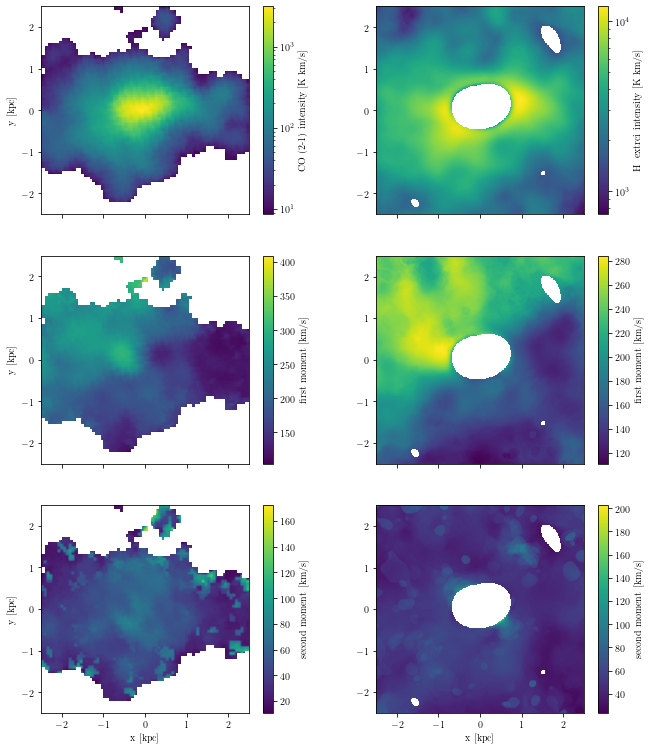

In [9]:
### showing moment map
row = 3; col=2;
fig, axs = plt.subplots(row, col, figsize=(11,13), sharex=True, sharey=False)
extent_a = [ex_co, ex_hi]

sp_a = ['CO_2_1', 'HI']
spl_a = ['CO (2-1)', 'H~\textrc{i}']
for j, sp, spl, sp_r  in zip(range(len(sp_a)), sp_a, spl_a, extent_a):
    locals()['p0'+str(j)]=axs[0][j].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(), extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.], 
                       )#vmin=10**-0.7, vmax=10**2.9)
    cb0 = fig.colorbar(eval('p0'+str(j)), ax = axs[0][j])
    cb0.set_label(r'%s intensity [K km/s]'%spl)

    locals()['p1'+str(j)]=axs[1][j].imshow((eval(sp+'_m1')+211), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],)# vmin=80, vmax=330)
    cb1 = fig.colorbar(eval('p1'+str(j)), ax= axs[1][j])
    cb1.set_label(r'first moment [km/s]')

    locals()['p2'+str(j)]=axs[2][j].imshow(eval(sp+'_m2'), origin='lower', extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],)# vmin=1, vmax=73  )
    cb2 = fig.colorbar(eval('p2'+str(j)), ax =axs[2][j])
    cb2.set_label(r'second moment [km/s]')
    
    if j==0:
        for i in range(3):
            axs[i][j].set_ylabel('y [kpc]')
    axs[2][j].set_xlabel('x [kpc]')

plt.savefig('figure/moment_leroy15.pdf')

<a id='img&spct'></a>
### Image & Spectrums
[Back](#contents)

In [10]:
pos_a_u_co = [1.2]*4+[0.8]*5
pos_t_u_co = [-.8, -.4, 0., .8]+[-.8, -.4, 0., .4, .8]

pos_a_l_co = [-1.2]*4+[-0.8]*5
pos_t_l_co = [-.8, -.4, 0., .4]+[-.8, -.4, 0., .4, .8]

pos_a_u_hi = [2.0]*5+[1.5]*5+[1.0]*5
pos_t_u_hi = [-1.0, -.5, 0., .5, 1.0]*3

pos_a_l_hi = [-2.0]*5+[-1.5]*5+[-1.0]*5
pos_t_l_hi = [-1.0, -.5, 0., .5, 1.0]*3

pos_a_u_hi_large = [6.]+[5.]*4+[4.]*4+[3.]*4
pos_t_u_hi_large = [-3]+[-3., -1.5, 1.5, 3.]*3
pos_a_l_hi_large = [-8.]*2+[-7.]*3+[-6.]*3+[-5.]*4+[-4.]*2+[-3.]*4
pos_t_l_hi_large = [-1.5, 1.5]+[-1.5, 1.5, 3.]+[-1.5, 0., 1.5]+[-3, -1.5, 0., 3.]\
                              +[-1.5, 1.5] + [-3., -1.5, 0., 1.5]

In [11]:
ex_hi_large

16.68

<ipython-input-12-ac31910c0315>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  locals()['p0'+str(i)]=axs[0][i].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(),
<ipython-input-12-ac31910c0315>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  locals()['p0'+str(i)]=axs[0][i].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(),
<ipython-input-12-ac31910c0315>:17: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  locals()['p0'+str(i)]=axs[0][i].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(),


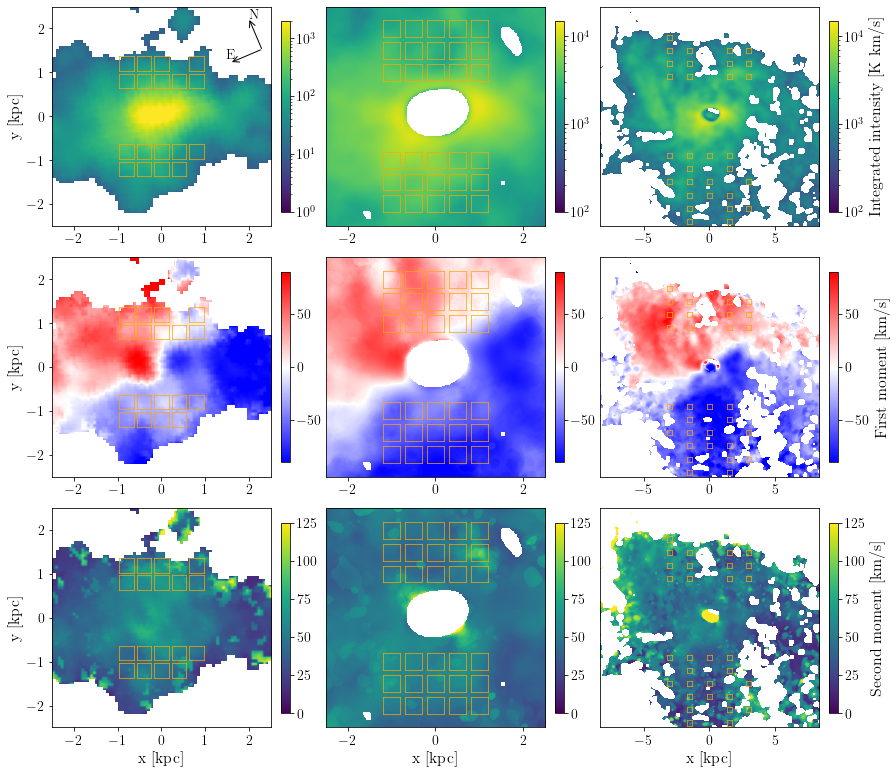

In [12]:
plt.rcParams.update({'font.size': 14})
### showing moment map
mk = 's'
s = 10**2
row = 3; col=3;
fig, axs = plt.subplots(row, col, figsize=(13,11), sharex=False, sharey=False, \
                        gridspec_kw = {'wspace':0.15, 'hspace':0.0})
extent_a = [ex_co, ex_hi, ex_hi_large]

sp_a = ['CO_2_1', 'HI', 'HI_l']
sp_a2 = ['co', 'hi', 'hi_large']
n_p_a = [5 , 23, 23]
vmin_a = [1, 100, 100]
vmax_a = [2e3, 1.5e4, 1.5e4]

for i, sp, sp2, n_p, sp_r, vmin, vmax in zip(range(len(sp_a)), sp_a, sp_a2, n_p_a, extent_a, vmin_a, vmax_a):
    locals()['p0'+str(i)]=axs[0][i].imshow(eval(sp+'_m0'), origin='lower', Norm = LogNorm(), 
                                           extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.], vmin=vmin, vmax=vmax )
    
    locals()['p1'+str(i)]=axs[1][i].imshow(eval(sp+'_m1'), origin='lower', 
                                           extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.],
                                           cmap="bwr", vmin=-90, vmax=90 )

    locals()['p2'+str(i)]=axs[2][i].imshow(eval(sp+'_m2'), origin='lower', 
                                           extent=[-sp_r/2.,sp_r/2., -sp_r/2.,sp_r/2.], 
                                           vmin=0, vmax=125 )

    cb0 = fig.colorbar(eval('p0'+str(i)), ax = axs[0][i], fraction=0.04, pad=0.04)
    cb0.ax.tick_params(labelsize=14)
    cb1 = fig.colorbar(eval('p1'+str(i)), ax = axs[1][i], fraction=0.04, pad=0.04)
    cb1.ax.tick_params(labelsize=14)
    cb2 = fig.colorbar(eval('p2'+str(i)), ax =axs[2][i], fraction=0.04, pad=0.04)
    cb2.ax.tick_params(labelsize=14)
    if i==2:
        cb0.set_label('Integrated intensity [K km/s]',size=16)
        cb1.set_label('First moment [km/s]',size=16)
        cb2.set_label('Second moment [km/s]',size=16)   
        
    
    for j in range(3):
        w_a = n_p*eval('cdel_%s'%sp2) # width of the aperture 
        for p_t, p_a in zip( eval('pos_t_u_%s'%sp2), eval('pos_a_u_%s'%sp2) ):
            l_e = p_t-w_a/2; r_e = p_t+w_a/2; u_e = p_a+w_a/2; d_e = p_a-w_a/2 
            axs[j][i].plot(np.linspace(l_e, r_e, 10), [u_e]*10, c='orange', linewidth=0.7)
            axs[j][i].plot(np.linspace(l_e, r_e, 10), [d_e]*10, c='orange', linewidth=0.7)
            axs[j][i].plot([l_e]*10, np.linspace(d_e, u_e, 10), c='orange', linewidth=0.7)
            axs[j][i].plot([r_e]*10, np.linspace(d_e, u_e, 10), c='orange', linewidth=0.7)
        for p_t, p_a in zip( eval('pos_t_l_%s'%sp2), eval('pos_a_l_%s'%sp2) ):
            l_e = p_t-w_a/2; r_e = p_t+w_a/2; u_e = p_a+w_a/2; d_e = p_a-w_a/2 
            axs[j][i].plot(np.linspace(l_e, r_e, 10), [u_e]*10, c='orange', linewidth=0.7)
            axs[j][i].plot(np.linspace(l_e, r_e, 10), [d_e]*10, c='orange', linewidth=0.7)
            axs[j][i].plot([l_e]*10, np.linspace(d_e, u_e, 10), c='orange', linewidth=0.7)
            axs[j][i].plot([r_e]*10, np.linspace(d_e, u_e, 10), c='orange', linewidth=0.7)
        axs[j][0].set_ylabel('y [kpc]',fontsize=16)
        
        if i!=0:
            axs[j][i].set_yticks([])
    axs[2][i].set_xlabel('x [kpc]',fontsize=16)
    
        
        
angle = 23/180*np.pi
axs[0][0].annotate('', xy=(2.3, 1.5),  xycoords='data',
            xytext=(2.3-0.8*np.sin(angle), 1.5+0.8*np.cos(angle) ), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle="<-",connectionstyle="arc3"),
            horizontalalignment='right', verticalalignment='top',size=15,
            )

axs[0][0].annotate('', xy=(2.3, 1.53),  xycoords='data',
            xytext=(2.3-0.8*np.cos(angle), 1.53-0.8*np.sin(angle)), textcoords='data',
            arrowprops=dict(facecolor='black', arrowstyle="<-",connectionstyle="arc3"),
            horizontalalignment='right', verticalalignment='top',size=15,
            )

axs[0][0].text(2.3-0.8*np.sin(angle), 1.5+0.8*np.cos(angle), 'N')
axs[0][0].text(2.2-0.8*np.cos(angle), 1.63-0.8*np.sin(angle), 'E')

plt.subplots_adjust(hspace=0, wspace=0, left=0.08, top=0.99, bottom=0.04, right=0.92)
plt.savefig('figure/spectra_on_map.pdf')

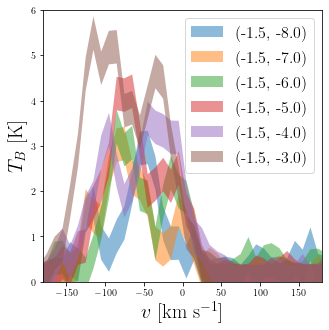

In [10]:
#v_cut=0
#v_r = 250
#v_l = -250
#v_sm_edge = np.linspace(v_l,v_r,51)
#ppv_rot, v_ppv, sigma, spct_dat, sigma_spct, v, pos_t, pos_a, pos_ix_a, pos_iy_a = \
#wodp.read_wind_data(obj='M82', line='HI', side='south', v_cut=v_cut, v_sm_edge=v_sm_edge, fov='full')
#idx_a = [0,2,5,9,12,15] 

u = v*1e5/v0 # dimensionless velocity
fig, axs = plt.subplots(1,1, figsize=(5,5))
for i in idx_a:
    #pos_a = pos_a[i]
    #pos_t = pos_t[i]
    # observation
    plt.fill_between(v, spct_dat[i]-sigma_spct, spct_dat[i]+sigma_spct, alpha=0.5, label = r'(%.1f, %.1f)'%(pos_t[i], pos_a[i]))
    
plt.ylabel('$T_B$ [K]', fontsize=20);
plt.xlabel('$v$ [km s$^{-1}$]', fontsize=20);
plt.legend(fontsize=16)
plt.axis([-180,180,0,6.])
plt.savefig('figure/HI_spec_south_-1.5kpc.pdf')



derive the noise level of our stacked spectra.
$$\sigma_{\rm beam} = \frac{\sigma}{\sqrt{S_{\rm beam}} }$$

$$\sigma_{\rm aper} = \frac{\sigma}{ \sqrt{S_{\rm aper}} }$$

$$\sigma_{\rm aper} = \frac{\sigma_{\rm beam}}{\sqrt{S_{\rm aper}/S_{\rm beam}}}$$

(typo in Martini18 paper)

### absorption line

In [13]:
# we will not use the absorption line for M82 as it is an edge on galaxy

In [ ]:
plt.scatter(pos_a_u_co, pos_t_u_co, c=v_sh_a, cmap="bwr")

In [6]:
pos_a = [-8.]*2+[-7.]*3+[-6.]*3+[-5.]*4+[-4.]*2+[-3.]*4
pos_t = [-1.5, 1.5]+[-1.5, 1.5, 3.]+[-1.5, 0., 1.5]+[-3, -1.5, 0., 3.]\
                              +[-1.5, 1.5] + [-3., -1.5, 0., 1.5]